Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [1]:
# Importing all the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [2]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")

# generating one row
df = data.sample(frac =.10)


In [3]:
df.count()

InvoiceNo      54191
StockCode      54191
Description    54047
Quantity       54191
InvoiceDate    54191
UnitPrice      54191
CustomerID     40854
Country        54191
dtype: int64

In [4]:
df.describe()

Quantity     UnitPrice    CustomerID
count  54191.000000  54191.000000  40854.000000
mean       8.633648      4.059886  15276.565722
std      322.600781     31.137656   1713.563931
min   -74215.000000      0.000000  12346.000000
25%        1.000000      1.250000  13924.000000
50%        3.000000      2.080000  15129.000000
75%       10.000000      4.130000  16775.000000
max     4800.000000   5575.280000  18287.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54191 entries, 33054 to 345531
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54047 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40854 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [6]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      144
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13337
Country            0
dtype: int64

In [7]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.isocalendar().week
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

InvoiceNo StockCode              Description  Quantity  \
33054     539217     22567  20 DOLLY PEGS RETROSPOT        12   
6114      536876    85099B  JUMBO BAG RED RETROSPOT         2   
108443    545534     22668        PINK BABY BUNTING         5   
317301    564758     20670        VIP HOLIDAY PURSE         2   
172555    551547    85049g   CHOCOLATE BOX RIBBONS          1   

               InvoiceDate  UnitPrice  CustomerID         Country  Sales  \
33054  2010-12-16 12:46:00       1.25     15394.0  United Kingdom  15.00   
6114   2010-12-03 11:36:00       4.21         NaN  United Kingdom   8.42   
108443 2011-03-03 14:05:00       2.95     17652.0  United Kingdom  14.75   
317301 2011-08-30 10:39:00       2.46         NaN  United Kingdom   4.92   
172555 2011-05-03 09:44:00       2.46         NaN  United Kingdom   2.46   

        Year  Month  Week Year_Month  Hour  Day is_cancelled   weekday  \
33054   2010     12    50    2010-12    12   16           No  Thursday   
6114    2010     12    48    2010-12    11    3           No    Friday   
108443  2011      3     9    2011-03    14    3           No  Thursday   
317301  2011      8    35    2011-08    10   30           No   Tuesday   
172555  2011      5    18    2011-05     9    3           No   Tuesday   

       Quarter       Date  
33054       Q3 2010-12-16  
6114        Q3 2010-12-03  
108443      Q1 2011-03-03  
317301      Q2 2011-08-30  
172555      Q2 2011-05-03

CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

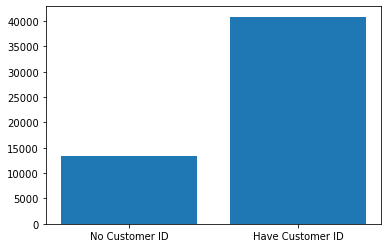

In [8]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])


In [9]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=df.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=df.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

In [10]:
df_=df[df.is_cancelled=='No']
del df

In [11]:
sales_by_date = df_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

In [12]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [13]:
customer_by_month1 = df_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = df_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

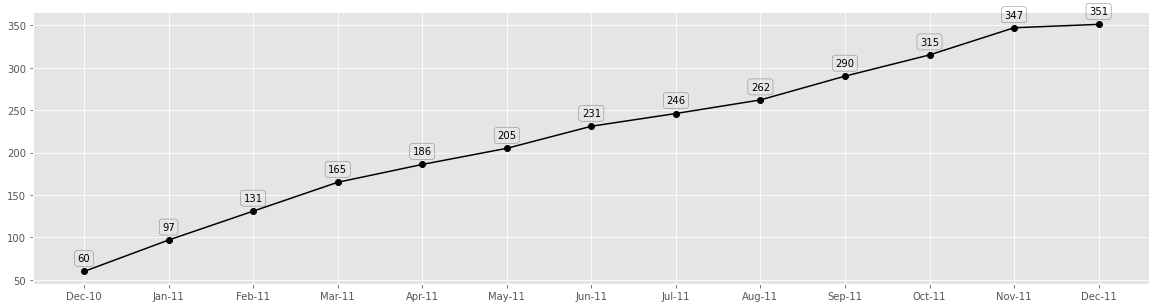

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month


Customer acquisition VS Sales contribution

In [15]:
customer_sales = df_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

Frequent purchasing:
Most of customers made their next purchase after one or two months of first purchase.
There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months.33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

Hourly sales

In [16]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

In [17]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=df_).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

                sum_sq       df          F        PR(>F)
C(Hour)   1.154090e+06     13.0  17.299253  1.262492e-40
Residual  2.734167e+08  53279.0        NaN           NaN


In [18]:
LRFM = df_.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="InvoiceNo", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = df_.groupby('CustomerID')['Date'].max() - df_.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

CustomerID  Frequency  Monetary  Length_of_stay
0     12347.0          7    284.86           365.0
1     12348.0          1     13.20             0.0
2     12349.0          1     55.26             0.0
3     12350.0          1     45.00             0.0
4     12352.0          4    137.98           260.0

#### 3 Dimensional View

In [19]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show()

K Means Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

In [21]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show()

del [error,silhouette,rng,km,lbls,X]

Creating Cluster

In [22]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

Sample vs Silhouette

In [23]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show()


In [24]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show()

Cluster 3 Dimensional View

In [25]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show()

Bivariate view

In [26]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Length_of_stay
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Length of Stay",title='Sales vs Length of Stay'
                  ,width=800,height=500)
fig.show()

In [27]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Frequency
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Frequency",title='Sales vs Frequency'
                  ,width=800,height=500)
fig.show()

### Time Series Forecasting

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [29]:
ds_weekly = df_.groupby(by=['Year','Week'])['Sales'].sum().reset_index()
ds_daily = df_.groupby(by=['Date'])['Sales'].sum().reset_index()

In [30]:
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title='Weekly'):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actual ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Predict',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actual',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Predict',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Forecast',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title=title,yaxis_title="Sales",title=title +' Trend'
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()


Weekly sales

In [31]:
fig = go.Figure(data=[go.Scatter(x=ds_weekly.index,y=ds_weekly.Sales)])
fig.update_layout(xaxis_title="Week",yaxis_title="Sales",title='Weekly Trend',height=400,template='ggplot2')
fig.show()

Daily sales

In [32]:
fig = go.Figure(data=[go.Scatter(x=ds_daily.Date,y=ds_daily.Sales)])
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Trend',height=400,template='ggplot2')
fig.show()


Train-Test split

In [33]:
series_date=ds_daily.Sales
split_time = 250
time_d=np.arange(len(ds_daily))
xtrain_d=series_date[:split_time]
xtest_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',xtrain_d.shape)
print('Testing Set Size ',xtest_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [34]:
series=ds_weekly.Sales
split_time = 45
time=np.arange(len(ds_weekly))
xtrain=series[:split_time]
xtest=series[split_time:]
timeTrain = time[:split_time]
timeTest = time[split_time:]
print('Full Set Size ',series.shape)
print('Training Set Size ',xtrain.shape)
print('Testing Set Size ',xtest.shape)

Full Set Size  (53,)
Training Set Size  (45,)
Testing Set Size  (8,)


In [35]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(xtrain, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   45
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -443.389
Date:                Thu, 07 Jan 2021   AIC                            894.778
Time:                        18:52:54   BIC                            901.915
Sample:                             0   HQIC                           897.425
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0087      0.629     -0.014      0.989      -1.241       1.223
ma.L1         -0.5757      0.629     -0.915      0.360      -1.809       0.658
ma.L2         -0.2953      0.433     -0.682      0.4

## Time-series Model -ARIMA

In [36]:
from statsmodels.tsa.arima.model import ARIMA
s_model = ARIMA(endog=xtrain_d , order=(1, 1, 1))
s_model_fit=s_model.fit()
print(s_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2209.542
Date:                Thu, 07 Jan 2021   AIC                           4425.085
Time:                        18:52:54   BIC                           4435.637
Sample:                             0   HQIC                          4429.332
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0217      0.088      0.247      0.805      -0.150       0.194
ma.L1         -0.9179      0.027    -34.238      0.000      -0.970      -0.865
sigma2      2.965e+06   1.41e+05     21.081      0.0

In [37]:
ytrain_pred = model_fit.predict()
ytest_pred = model_fit.predict(start=min(timeTest),end=max(timeTest),dynamic=True)
print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest)**2)))
forecast = model_fit.forecast(20, alpha=0.05)
plot_(t_train = timeTrain,t_test = timeTest,x_train = xtrain,x_test = xtest,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Weekly')

MSE Train : 6150.8284823840195
MSE Test : 11772.323965817772


In [38]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.api import het_goldfeldquandt
from sklearn.metrics import r2_score

In [39]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(LRFM[['Frequency', 'Length_of_stay']],LRFM.Monetary
                                             ,test_size=.3,random_state=49,shuffle=True)
print(xtrain1.shape)
print(xtest1.shape)

(2650, 2)
(1137, 2)


In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
# poly = PolynomialFeatures(2)
# xtest = poly.fit_transform(xtest1)
# xtrain = poly.fit_transform(xtrain1)

inp_test=sm.add_constant(np.log1p(xtest1))
inp_train=sm.add_constant(np.log1p(xtrain1))
ytrain=np.log1p(ytrain1)
ytest=np.log1p(ytest1)
ols=sm.OLS(ytrain,inp_train)
model=ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Monetary   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     1893.
Date:                Thu, 07 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:55:25   Log-Likelihood:                -3263.5
No. Observations:                2650   AIC:                             6533.
Df Residuals:                    2647   BIC:                             6551.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5616      0.038     67.

In [42]:
print('Below are the interprataion of all 2 coeficients')
print('if customers increase the frequency of purchase by 1 percent then we can expect that sales will increase by 1.3%')
print('As customers are staying long with business then we can expect that sales will increase by 0.05%')

Below are the interprataion of all 2 coeficients
if customers increase the frequency of purchase by 1 percent then we can expect that sales will increase by 1.3%
As customers are staying long with business then we can expect that sales will increase by 0.05%


In [43]:
ytrain_pred=model.predict(inp_train)
ytest_pred=model.predict(inp_test)

train_res=ytrain-ytrain_pred
test_res=ytest-ytest_pred

train_mse= np.mean(train_res**2)
test_mse= np.mean(test_res**2)

print('Train MSE:{0:.4f}'.format(train_mse))
print('Test MSE:{0:.4f}'.format(test_mse))

Train MSE:0.6874
Test MSE:0.6316


R Squared

In [44]:
r2_train=r2_score(ytrain,ytrain_pred)
r2_test=r2_score(ytest,ytest_pred)
print('R square Train:{0:.4f}'.format(r2_train))
print('R square Test:{0:.4f}'.format(r2_test))

R square Train:0.5886
R square Test:0.6035


Linear rainbow Test

In [ ]:
pval=linear_rainbow(res=model,frac=0.5)[1]
print('P value {0:.2f}'.format(pval))

Actual vs Predicted

In [47]:
fig = make_subplots(rows=1, cols=2,subplot_titles=['Train','Test'])
fig.add_trace(go.Scatter(x=ytrain,y=ytrain_pred, mode='markers'
                         ,marker=dict(size=4,colorscale='Viridis',opacity=0.8)),row=1, col=1)
fig.add_trace(go.Scatter(x=ytest,y=ytest_pred, mode='markers'
                         ,marker=dict(size=4,colorscale='Viridis',opacity=0.8)),row=1, col=2)
fig.update_xaxes(title_text="Actual", row=1, col=1)
fig.update_yaxes(title_text="Predicted", row=1, col=1)
fig.update_xaxes(title_text="Actual", row=1, col=2)
fig.update_yaxes(title_text="Predicted", row=1, col=2)
fig.update_layout(height=400, width=800,template='ggplot2')
fig.show()